# 準備

## Googleドライブのマウント

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [2]:
import sys
sys.path.append('/content/drive/My Drive/DNN_code')

# simple convolution network

## image to column

In [3]:
import pickle
import numpy as np
from collections import OrderedDict
from common import layers
from common import optimizer
from data.mnist import load_mnist
import matplotlib.pyplot as plt

# 画像データを２次元配列に変換
'''
input_data: 入力値
filter_h: フィルターの高さ
filter_w: フィルターの横幅
stride: ストライド
pad: パディング
'''
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    #col = col.transpose(0, 4, 5, 1, 2, 3) # (N, C, filter_h, filter_w, out_h, out_w) -> (N, filter_w, out_h, out_w, C, filter_h)    
    
    col = col.reshape(N * out_h * out_w, -1)
    return col

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] im2colの処理を確認しよう
・関数内でtransposeの処理をしている行をコメントアウトして下のコードを実行してみよう<br>
・input_dataの各次元のサイズやフィルターサイズ・ストライド・パディングを変えてみよう

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [4]:
# im2colの処理確認
input_data = np.random.rand(2, 1, 4, 4)*100//1 # number, channel, height, widthを表す
print('========== input_data ===========\n', input_data)
print('==============================')
filter_h = 6
filter_w = 4
stride = 2
pad = 1
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print('============= col ==============\n', col)
print('==============================')

========== input_data ===========
 [[[[25. 35. 68. 69.]
   [ 2. 62. 20. 21.]
   [13. 87. 61. 22.]
   [ 8. 12. 84. 15.]]]


 [[[46. 15. 93. 85.]
   [31. 68. 82. 32.]
   [81.  8.  6. 71.]
   [16. 16. 93. 14.]]]]
============= col ==============
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0. 35. 25. 68. 35. 69. 68.  0.  0. 62.
   2. 20. 62. 21. 20.  0.]
 [ 0. 87. 13. 61. 87. 22. 61.  0.  0. 12.  8. 84. 12. 15. 84.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 15. 46. 93. 15. 85. 93.  0.  0. 68.
  31. 82. 68. 32. 82.  0.]
 [ 0.  8. 81.  6.  8. 71.  6.  0.  0. 16. 16. 93. 16. 14. 93.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]]


## column to image

In [5]:
# ２次元配列を画像データに変換
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_shape
    # 切り捨て除算    
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2) # (N, filter_h, filter_w, out_h, out_w, C)

    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

## col2imの処理を確認しよう
・im2colの確認で出力したcolをimageに変換して確認しよう

In [6]:
img = col2im(col, input_shape=input_data.shape, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print(img)

[[[[  0.  87.  22.  61.]
   [ 35.  25.  80.   8.]
   [ 69.  80.  15.  84.]
   [ 62.   2.  20.   0.]]]


 [[[  0.   8.  71.   6.]
   [ 15.  46. 109.  16.]
   [ 85. 109.  14.  93.]
   [ 68.  31.  82.   0.]]]]


## convolution class

In [7]:
class Convolution:
    # W: フィルター, b: バイアス
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # フィルター・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        # FN: filter_number, C: channel, FH: filter_height, FW: filter_width
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        # 出力値のheight, width
        out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)
        
        # xを行列に変換
        col = im2col(x, FH, FW, self.stride, self.pad)
        # フィルターをxに合わせた行列に変換
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        # 計算のために変えた形式を戻す
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        # dcolを画像データに変換
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


## pooling class

In [8]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # xを行列に変換
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # プーリングのサイズに合わせてリサイズ
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 行ごとに最大値を求める
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        # 整形
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


## sinple convolution network class

In [9]:
class SimpleConvNet:
    # conv - relu - pool - affine - relu - affine - softmax
    def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']        
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = layers.Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = layers.Relu()
        self.layers['Pool1'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = layers.Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = layers.Relu()
        self.layers['Affine2'] = layers.Affine(self.params['W3'], self.params['b3'])

        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x):
        for key in self.layers.keys():
            x = self.layers[key].forward(x)
        return x
        
    def loss(self, x, d):
        y = self.predict(x)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1 : d = np.argmax(d, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            td = d[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td) 
        
        return acc / x.shape[0]

    def gradient(self, x, d):
        # forward
        self.loss(x, d)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grad['W2'], grad['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W3'], grad['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grad

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.3646
                : 10. 正答率(テスト) = 0.314
Generation: 20. 正答率(トレーニング) = 0.6134
                : 20. 正答率(テスト) = 0.593
Generation: 30. 正答率(トレーニング) = 0.742
                : 30. 正答率(テスト) = 0.686
Generation: 40. 正答率(トレーニング) = 0.7706
                : 40. 正答率(テスト) = 0.739
Generation: 50. 正答率(トレーニング) = 0.819
                : 50. 正答率(テスト) = 0.805
Generation: 60. 正答率(トレーニング) = 0.85
                : 60. 正答率(テスト) = 0.828
Generation: 70. 正答率(トレーニング) = 0.8726
                : 70. 正答率(テスト) = 0.836
Generation: 80. 正答率(トレーニング) = 0.8692
                : 80. 正答率(テスト) = 0.838
Generation: 90. 正答率(トレーニング) = 0.8854
                : 90. 正答率(テスト) = 0.852
Generation: 100. 正答率(トレーニング) = 0.8826
                : 100. 正答率(テスト) = 0.863
Generation: 110. 正答率(トレーニング) = 0.8912
                : 110. 正答率(テスト) = 0.865
Generation: 120. 正答率(トレーニング) = 0.9022
                : 120. 正答率(テスト) = 0.869
Generation: 130. 正答率(トレーニング) = 0.9068
                : 130. 正答率(テスト) = 0.88

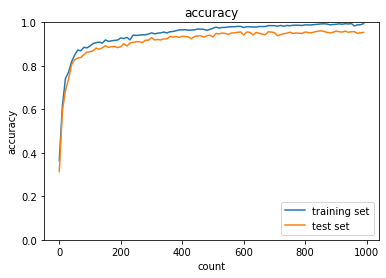

In [10]:
from common import optimizer

# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

print("データ読み込み完了")

# 処理に時間のかかる場合はデータを削減 
x_train, d_train = x_train[:5000], d_train[:5000]
x_test, d_test = x_test[:1000], d_test[:1000]


network = SimpleConvNet(input_dim=(1,28,28), conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

optimizer = optimizer.Adam()

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10



for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]
    
    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()